# Bus Delay Prediction Model

Building a LightGBM model to predict bus delay times (delay_seconds) in Metro Vancouver.

## Table of Contents
1. Setup & Imports
2. Load Data
3. **Exploratory Data Analysis (EDA)**
4. Feature Engineering
5. Model Training
6. Evaluation & Analysis

---
## 1. Setup & Imports

In [5]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import psycopg2
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

load_dotenv()
DATABASE_URL = os.environ.get('DATABASE_URL')

# Selected routes (13 routes x 2 directions = 26 route-directions)
SELECTED_ROUTES = [
    '130', '123', '144', '106', '160', '110', '116',  # New Westminster/Burnaby
    '006', '019',  # Vancouver Downtown
    '049', '100',  # South Vancouver
    '240', '255',  # North Vancouver
]

print(f"Selected {len(SELECTED_ROUTES)} routes: {SELECTED_ROUTES}")

Selected 13 routes: ['130', '123', '144', '106', '160', '110', '116', '006', '019', '049', '100', '240', '255']


---
## 2. Load Data

In [6]:
conn = psycopg2.connect(DATABASE_URL)

# Bus Delays
routes_placeholder = ','.join([f"'{r}'" for r in SELECTED_ROUTES])
bus_df = pd.read_sql(f"""
    SELECT bd.route_id, r.route_short_name, r.route_long_name,
           bd.stop_id, bd.trip_id, bd.delay_seconds, bd.recorded_at,
           s.stop_lat, s.stop_lon, s.stop_name, t.direction_id
    FROM bus_delays bd
    JOIN routes r ON bd.route_id = r.route_id
    JOIN stops s ON bd.stop_id = s.stop_id
    JOIN trips t ON bd.trip_id = t.trip_id
    WHERE r.route_short_name IN ({routes_placeholder})
      AND bd.route_id IS NOT NULL
""", conn)

# Stop sequences
stop_seq_df = pd.read_sql("SELECT DISTINCT trip_id, stop_id, stop_sequence FROM stop_times", conn)

# Weather
weather_df = pd.read_sql("""
    SELECT station_id, station_name, recorded_at, lat, lon,
           temperature_c, humidity_percent, wind_speed_kmh, 
           precipitation_mm, visibility_km
    FROM weather WHERE recorded_at >= '2026-01-10'
""", conn)

# Road conditions
road_df = pd.read_sql("""
    SELECT event_id, event_type, severity, lat, lon, 
           created_at, updated_at, status, road_name
    FROM road_conditions WHERE lat IS NOT NULL
""", conn)

conn.close()

print(f"Data Loaded:")
print(f"   Bus delays:      {len(bus_df):>10,} records")
print(f"   Stop sequences:  {len(stop_seq_df):>10,} records")
print(f"   Weather:         {len(weather_df):>10,} records")
print(f"   Road conditions: {len(road_df):>10,} records")

/var/folders/pw/m9sdxp0522n2ff6scy30rjx80000gn/T/ipykernel_54308/143300035.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bus_df = pd.read_sql(f"""
/var/folders/pw/m9sdxp0522n2ff6scy30rjx80000gn/T/ipykernel_54308/143300035.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stop_seq_df = pd.read_sql("SELECT DISTINCT trip_id, stop_id, stop_sequence FROM stop_times", conn)
/var/folders/pw/m9sdxp0522n2ff6scy30rjx80000gn/T/ipykernel_54308/143300035.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weather_df = pd.read_

Data Loaded:
   Bus delays:         222,666 records
   Stop sequences:   1,835,312 records
   Weather:            125,866 records
   Road conditions:        838 records


/var/folders/pw/m9sdxp0522n2ff6scy30rjx80000gn/T/ipykernel_54308/143300035.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  road_df = pd.read_sql("""


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Bus Delay Overview

In [7]:
# Convert timestamp
bus_df['recorded_at'] = pd.to_datetime(bus_df['recorded_at'], utc=True)

print("=" * 60)
print("BUS DELAY DATA OVERVIEW")
print("=" * 60)
print(f"\nData Period: {bus_df['recorded_at'].min().date()} to {bus_df['recorded_at'].max().date()}")
print(f"Total Records: {len(bus_df):,}")
print(f"Unique Routes: {bus_df['route_short_name'].nunique()}")
print(f"Unique Stops: {bus_df['stop_id'].nunique()}")

print("\nDelay Statistics (seconds):")
print(bus_df['delay_seconds'].describe().to_string())

BUS DELAY DATA OVERVIEW

Data Period: 2026-01-10 to 2026-01-27
Total Records: 222,666
Unique Routes: 13
Unique Stops: 980

Delay Statistics (seconds):
count    222666.000000
mean         59.108175
std         305.370564
min       -2888.000000
25%         -43.000000
50%           6.000000
75%         105.000000
max       10848.000000


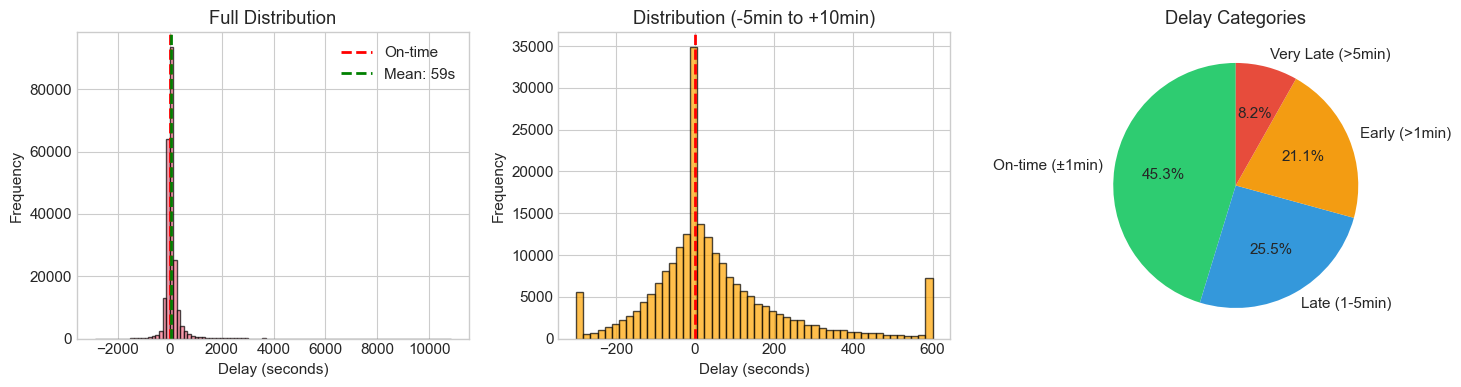

In [8]:
# Delay Distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Full distribution
axes[0].hist(bus_df['delay_seconds'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Delay (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Full Distribution')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='On-time')
axes[0].axvline(x=bus_df['delay_seconds'].mean(), color='g', linestyle='--', linewidth=2, label=f'Mean: {bus_df["delay_seconds"].mean():.0f}s')
axes[0].legend()

# Clipped distribution (-5min to +10min)
axes[1].hist(bus_df['delay_seconds'].clip(-300, 600), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Delay (seconds)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution (-5min to +10min)')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)

# Pie chart by category
delay_categories = pd.cut(bus_df['delay_seconds'], 
                          bins=[-np.inf, -60, 60, 300, np.inf],
                          labels=['Early (>1min)', 'On-time (±1min)', 'Late (1-5min)', 'Very Late (>5min)'])
cat_counts = delay_categories.value_counts()
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
axes[2].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[2].set_title('Delay Categories')

plt.tight_layout()
plt.savefig('eda_delay_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Delay by Route

In [9]:
# Route statistics
route_stats = bus_df.groupby(['route_short_name', 'route_long_name']).agg({
    'delay_seconds': ['count', 'mean', 'std', 'median'],
    'stop_id': 'nunique'
}).round(1)
route_stats.columns = ['Records', 'Mean Delay', 'Std Delay', 'Median Delay', 'Stops']
route_stats = route_stats.sort_values('Records', ascending=False)

print("\nRoute Statistics:")
display(route_stats)


Route Statistics:


,,Records,Mean Delay,Std Delay,Median Delay,Stops
route_short_name,route_long_name,,,,,
049,Metrotown Station/Dunbar Loop/UBC,38684,61.8,186.1,20.0,121
019,Metrotown Station/Stanley Park,27050,66.8,317.3,15.0,109
100,22nd St Station/Marpole Loop,23261,58.7,267.4,12.0,95
160,Port Coquitlam Station/Kootenay Loop,21959,42.0,266.8,0.0,110
240,Lynn Valley/Downtown,17087,139.1,409.9,27.0,75
130,Metrotown/Phibbs Exchange,14236,96.5,347.8,13.0,54
123,New West Station/Brentwood Station,13846,45.1,540.5,0.0,69
255,Dundarave/Capilano University,13345,97.6,326.5,0.0,101
144,SFU/Metrotown Station,12439,28.0,225.9,11.0,88


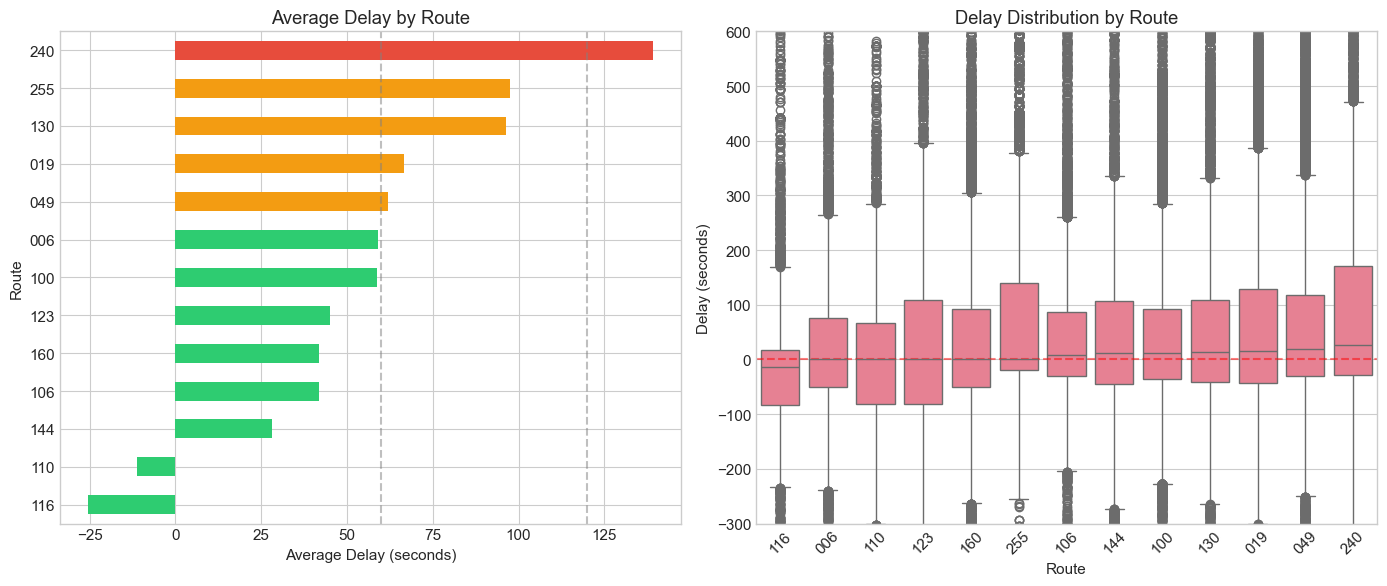

In [10]:
# Visualize by route
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mean delay by route
route_mean = bus_df.groupby('route_short_name')['delay_seconds'].mean().sort_values()
colors = ['#e74c3c' if x > 120 else '#f39c12' if x > 60 else '#2ecc71' for x in route_mean]
route_mean.plot(kind='barh', ax=axes[0], color=colors)
axes[0].set_xlabel('Average Delay (seconds)')
axes[0].set_ylabel('Route')
axes[0].set_title('Average Delay by Route')
axes[0].axvline(x=60, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(x=120, color='gray', linestyle='--', alpha=0.5)

# Box plot
route_order = bus_df.groupby('route_short_name')['delay_seconds'].median().sort_values().index
sns.boxplot(data=bus_df, x='route_short_name', y='delay_seconds', order=route_order, ax=axes[1])
axes[1].set_ylim(-300, 600)
axes[1].set_xlabel('Route')
axes[1].set_ylabel('Delay (seconds)')
axes[1].set_title('Delay Distribution by Route')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('eda_delay_by_route.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Temporal Patterns

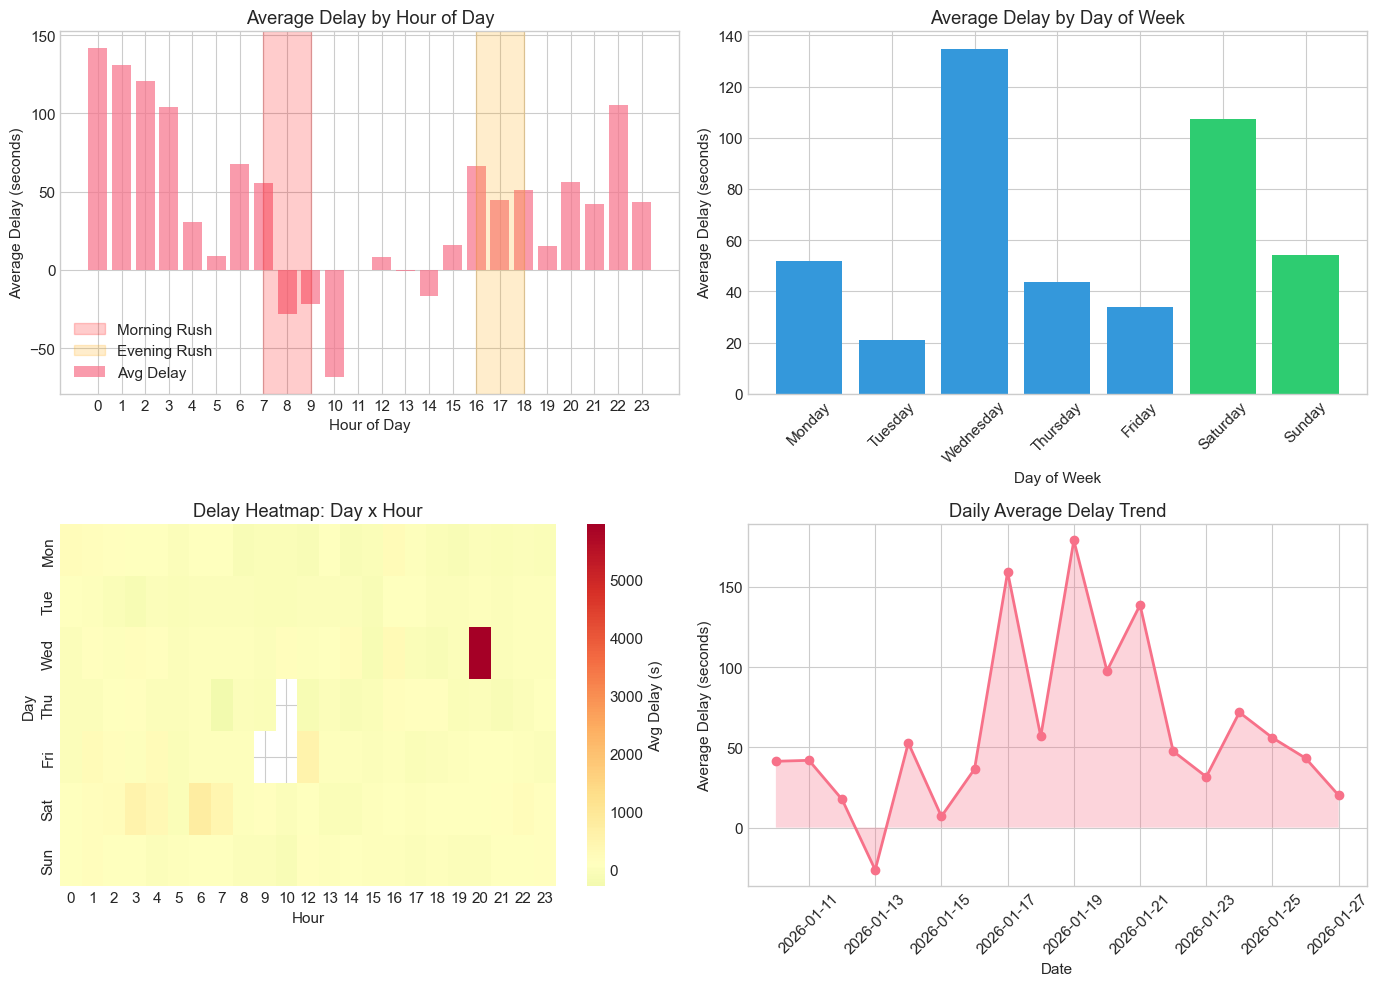

In [11]:
# Add time features for EDA
bus_df['hour'] = bus_df['recorded_at'].dt.hour
bus_df['day_of_week'] = bus_df['recorded_at'].dt.dayofweek
bus_df['day_name'] = bus_df['recorded_at'].dt.day_name()
bus_df['date'] = bus_df['recorded_at'].dt.date

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hourly pattern
hourly = bus_df.groupby('hour')['delay_seconds'].agg(['mean', 'count'])
ax1 = axes[0, 0]
ax1.bar(hourly.index, hourly['mean'], alpha=0.7, label='Avg Delay')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Delay (seconds)')
ax1.set_title('Average Delay by Hour of Day')
ax1.axvspan(7, 9, alpha=0.2, color='red', label='Morning Rush')
ax1.axvspan(16, 18, alpha=0.2, color='orange', label='Evening Rush')
ax1.legend()
ax1.set_xticks(range(0, 24))

# Daily pattern
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily = bus_df.groupby('day_name')['delay_seconds'].mean().reindex(day_order)
colors = ['#3498db']*5 + ['#2ecc71']*2
axes[0, 1].bar(daily.index, daily.values, color=colors)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Delay (seconds)')
axes[0, 1].set_title('Average Delay by Day of Week')
axes[0, 1].tick_params(axis='x', rotation=45)

# Heatmap: Hour x Day
heatmap_data = bus_df.pivot_table(values='delay_seconds', index='day_of_week', 
                                   columns='hour', aggfunc='mean')
heatmap_data.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.heatmap(heatmap_data, cmap='RdYlGn_r', center=100, ax=axes[1, 0], 
            cbar_kws={'label': 'Avg Delay (s)'})
axes[1, 0].set_title('Delay Heatmap: Day x Hour')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Day')

# Daily trend
daily_trend = bus_df.groupby('date')['delay_seconds'].mean()
axes[1, 1].plot(daily_trend.index, daily_trend.values, marker='o', linewidth=2)
axes[1, 1].fill_between(daily_trend.index, daily_trend.values, alpha=0.3)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Average Delay (seconds)')
axes[1, 1].set_title('Daily Average Delay Trend')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('eda_temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Weather Data Analysis

In [12]:
weather_df['recorded_at'] = pd.to_datetime(weather_df['recorded_at'], utc=True)

print("=" * 60)
print("WEATHER DATA OVERVIEW")
print("=" * 60)
print(f"\nPeriod: {weather_df['recorded_at'].min().date()} to {weather_df['recorded_at'].max().date()}")
print(f"Stations: {weather_df['station_name'].nunique()}")
print(f"\nWeather Statistics:")
print(weather_df[['temperature_c', 'humidity_percent', 'wind_speed_kmh', 
                  'precipitation_mm', 'visibility_km']].describe().round(2).to_string())

WEATHER DATA OVERVIEW

Period: 2026-01-10 to 2026-01-27
Stations: 15

Weather Statistics:
       temperature_c  humidity_percent  wind_speed_kmh  precipitation_mm
count      125866.00         125866.00       125766.00         123841.00
mean            4.37             87.84            6.22              0.37
std             3.59             14.04            7.32              9.45
min            -5.70             26.00            0.00              0.00
25%             1.70             82.00            1.40              0.00
50%             4.40             93.00            3.60              0.00
75%             7.20             98.00            7.80              0.00
max            13.10            100.00           57.30            650.20


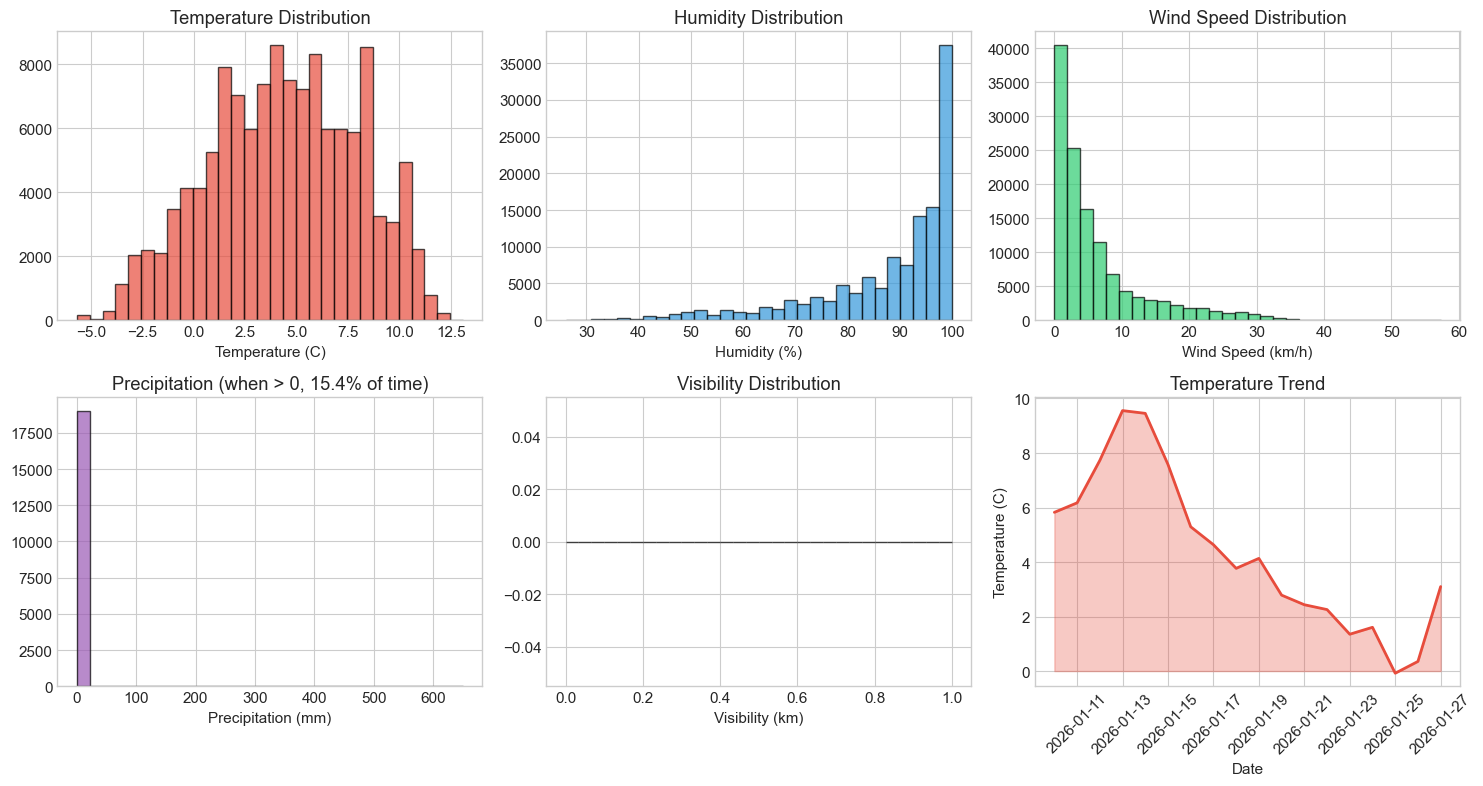

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Temperature distribution
axes[0, 0].hist(weather_df['temperature_c'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[0, 0].set_xlabel('Temperature (C)')
axes[0, 0].set_title('Temperature Distribution')

# Humidity
axes[0, 1].hist(weather_df['humidity_percent'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0, 1].set_xlabel('Humidity (%)')
axes[0, 1].set_title('Humidity Distribution')

# Wind speed
axes[0, 2].hist(weather_df['wind_speed_kmh'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[0, 2].set_xlabel('Wind Speed (km/h)')
axes[0, 2].set_title('Wind Speed Distribution')

# Precipitation
precip = weather_df['precipitation_mm'].dropna()
axes[1, 0].hist(precip[precip > 0], bins=30, edgecolor='black', alpha=0.7, color='#9b59b6')
axes[1, 0].set_xlabel('Precipitation (mm)')
axes[1, 0].set_title(f'Precipitation (when > 0, {(precip > 0).mean()*100:.1f}% of time)')

# Visibility
axes[1, 1].hist(weather_df['visibility_km'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='#f39c12')
axes[1, 1].set_xlabel('Visibility (km)')
axes[1, 1].set_title('Visibility Distribution')

# Temperature trend
weather_df['date'] = weather_df['recorded_at'].dt.date
temp_trend = weather_df.groupby('date')['temperature_c'].mean()
axes[1, 2].plot(temp_trend.index, temp_trend.values, linewidth=2, color='#e74c3c')
axes[1, 2].fill_between(temp_trend.index, temp_trend.values, alpha=0.3, color='#e74c3c')
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Temperature (C)')
axes[1, 2].set_title('Temperature Trend')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('eda_weather.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.5 Road Conditions Analysis

In [14]:
print("=" * 60)
print("ROAD CONDITIONS OVERVIEW")
print("=" * 60)
print(f"\nTotal Events: {len(road_df)}")
print(f"\nEvent Types:")
print(road_df['event_type'].value_counts().to_string())
print(f"\nSeverity Levels:")
print(road_df['severity'].value_counts().to_string())

ROAD CONDITIONS OVERVIEW

Total Events: 838

Event Types:
INCIDENT             332
CONSTRUCTION         208
WEATHER_CONDITION    186
ROAD_CONDITION       110
SPECIAL_EVENT          2

Severity Levels:
MINOR    629
MAJOR    209


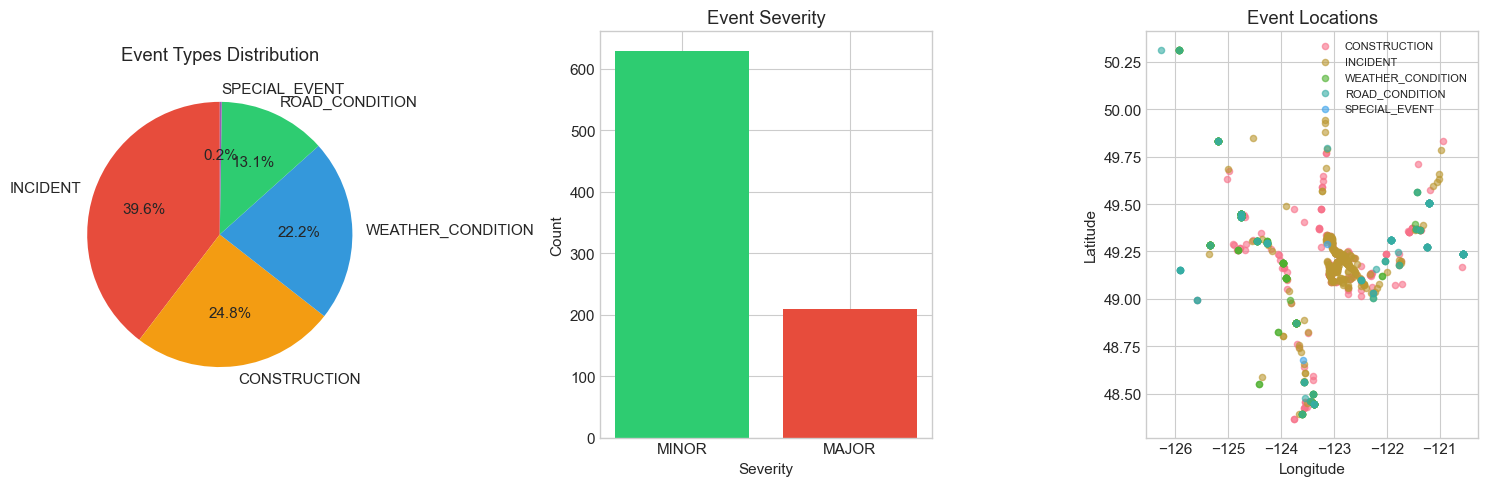

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Event types
event_counts = road_df['event_type'].value_counts()
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#9b59b6']
axes[0].pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', 
            colors=colors[:len(event_counts)], startangle=90)
axes[0].set_title('Event Types Distribution')

# Severity
severity_counts = road_df['severity'].value_counts()
severity_colors = {'MAJOR': '#e74c3c', 'MODERATE': '#f39c12', 'MINOR': '#2ecc71', 'UNKNOWN': '#95a5a6'}
axes[1].bar(severity_counts.index, severity_counts.values, 
            color=[severity_colors.get(s, '#3498db') for s in severity_counts.index])
axes[1].set_xlabel('Severity')
axes[1].set_ylabel('Count')
axes[1].set_title('Event Severity')

# Map of events
for event_type in road_df['event_type'].unique():
    subset = road_df[road_df['event_type'] == event_type]
    axes[2].scatter(subset['lon'], subset['lat'], label=event_type, alpha=0.6, s=20)
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].set_title('Event Locations')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.savefig('eda_road_conditions.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.6 Geographic Distribution

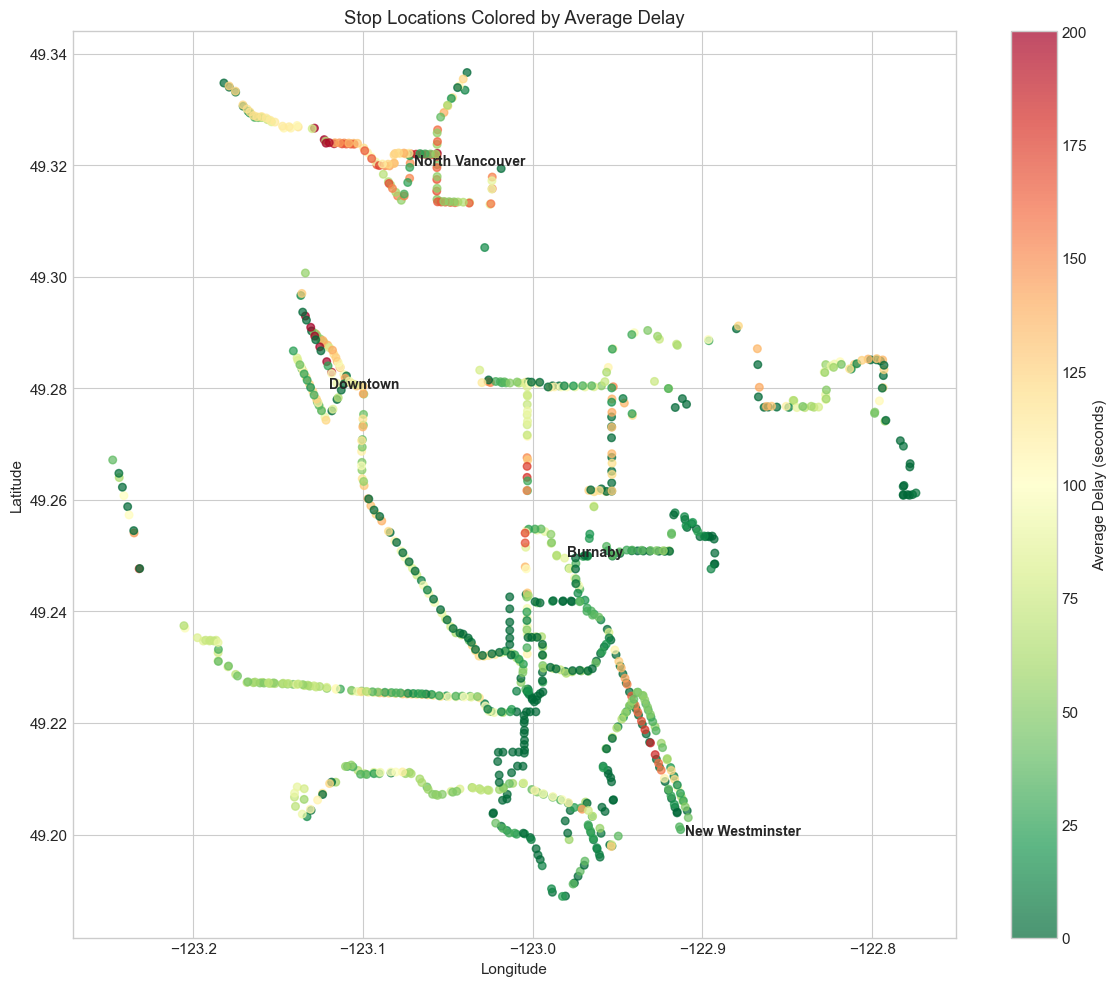

In [16]:
# Map of stops colored by average delay
stop_delay = bus_df.groupby(['stop_id', 'stop_lat', 'stop_lon', 'stop_name']).agg({
    'delay_seconds': 'mean',
    'route_short_name': 'first'
}).reset_index()

fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(stop_delay['stop_lon'], stop_delay['stop_lat'], 
                     c=stop_delay['delay_seconds'], cmap='RdYlGn_r',
                     s=30, alpha=0.7, vmin=0, vmax=200)
plt.colorbar(scatter, label='Average Delay (seconds)')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Stop Locations Colored by Average Delay')

# Add annotations for areas
ax.annotate('Downtown', xy=(-123.12, 49.28), fontsize=10, fontweight='bold')
ax.annotate('Burnaby', xy=(-122.98, 49.25), fontsize=10, fontweight='bold')
ax.annotate('New Westminster', xy=(-122.91, 49.20), fontsize=10, fontweight='bold')
ax.annotate('North Vancouver', xy=(-123.07, 49.32), fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_geographic.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Feature Engineering

In [17]:
# Time features (already added in EDA)
bus_df['is_weekend'] = (bus_df['day_of_week'] >= 5).astype(int)
bus_df['is_rush_hour'] = ((bus_df['hour'] >= 7) & (bus_df['hour'] <= 9) |
                          (bus_df['hour'] >= 16) & (bus_df['hour'] <= 18)).astype(int)

print("Time features added")

Time features added


In [18]:
# Stop sequence
bus_df = bus_df.merge(stop_seq_df, on=['trip_id', 'stop_id'], how='left')
bus_df['stop_sequence'] = bus_df['stop_sequence'].fillna(0)

print(f"Stop sequence added (range: {bus_df['stop_sequence'].min():.0f} - {bus_df['stop_sequence'].max():.0f})")

Stop sequence added (range: 1 - 61)


In [19]:
# Weather features
bus_df['weather_time'] = bus_df['recorded_at'].dt.floor('10min')
weather_df['weather_time'] = weather_df['recorded_at'].dt.floor('10min')

weather_agg = weather_df.groupby('weather_time').agg({
    'temperature_c': 'mean',
    'humidity_percent': 'mean',
    'wind_speed_kmh': 'mean',
    'precipitation_mm': 'mean',
    'visibility_km': 'mean',
}).reset_index()

bus_df = bus_df.merge(weather_agg, on='weather_time', how='left')

weather_cols = ['temperature_c', 'humidity_percent', 'wind_speed_kmh', 'precipitation_mm', 'visibility_km']
bus_df[weather_cols] = bus_df[weather_cols].fillna(method='ffill').fillna(method='bfill')

print(f"Weather features merged")

Weather features merged


In [20]:
# Road condition features
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

bus_df['active_incidents'] = 0
bus_df['active_construction'] = 0
bus_df['nearest_event_distance_km'] = 50.0

unique_stops = bus_df[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()
print(f"Processing {len(unique_stops)} unique stops...")

for i, (_, stop) in enumerate(unique_stops.iterrows()):
    if len(road_df) > 0:
        distances = haversine_distance(stop['stop_lat'], stop['stop_lon'],
                                        road_df['lat'].values, road_df['lon'].values)
        nearby = road_df[distances < 5]
        
        mask = bus_df['stop_id'] == stop['stop_id']
        bus_df.loc[mask, 'active_incidents'] = (nearby['event_type'] == 'INCIDENT').sum()
        bus_df.loc[mask, 'active_construction'] = (nearby['event_type'] == 'CONSTRUCTION').sum()
        bus_df.loc[mask, 'nearest_event_distance_km'] = distances.min() if len(distances) > 0 else 50.0

print("Road condition features added")

Processing 980 unique stops...
Road condition features added


In [21]:
# Feature summary
feature_cols = [
    'hour', 'day_of_week', 'is_weekend', 'is_rush_hour',
    'route_short_name', 'direction_id', 'stop_sequence', 'stop_lat', 'stop_lon',
    'temperature_c', 'humidity_percent', 'wind_speed_kmh', 'precipitation_mm', 'visibility_km',
    'active_incidents', 'active_construction', 'nearest_event_distance_km',
]

print("\nFeature Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   - Time:         4 features")
print(f"   - Route/Stop:   5 features")
print(f"   - Weather:      5 features")
print(f"   - Road:         3 features")

bus_df[feature_cols].describe().round(2)


Feature Summary:
   Total features: 17
   - Time:         4 features
   - Route/Stop:   5 features
   - Weather:      5 features
   - Road:         3 features


,hour,day_of_week,is_weekend,is_rush_hour,direction_id,stop_sequence,stop_lat,stop_lon,temperature_c,humidity_percent,wind_speed_kmh,precipitation_mm,visibility_km,active_incidents,active_construction,nearest_event_distance_km
count,222666.00,222666.00,222666.0,222666.00,222666.00,222666.00,222666.00,222666.00,222666.00,222666.00,222666.00,222666.00,0.0,222666.00,222666.00,222666.00
mean,12.13,3.29,0.5,0.23,0.51,22.99,49.25,-123.03,2.90,82.12,6.11,0.16,NaN,17.85,6.06,2.41
std,8.07,2.48,0.5,0.42,0.50,14.77,0.04,0.09,2.56,7.84,1.94,0.54,NaN,14.51,4.51,1.45
min,0.00,0.00,0.0,0.00,0.00,1.00,49.19,-123.25,-1.67,58.05,1.40,0.00,NaN,0.00,0.00,0.04
25%,4.00,1.00,0.0,0.00,0.00,11.00,49.22,-123.10,0.96,76.43,4.68,0.00,NaN,5.00,1.00,1.14
50%,15.00,5.00,1.0,0.00,1.00,21.00,49.24,-123.02,2.89,82.89,5.91,0.00,NaN,15.00,6.00,2.19
75%,19.00,6.00,1.0,0.00,1.00,34.00,49.28,-122.97,4.61,87.69,7.00,0.00,NaN,28.00,10.00,3.50
max,23.00,6.00,1.0,1.00,1.00,61.00,49.34,-122.77,11.01,98.17,13.47,3.84,NaN,60.00,14.00,5.92


---
## 5. Model Training

In [22]:
# Prepare data
bus_df = bus_df.dropna(subset=['delay_seconds', 'stop_lat', 'stop_lon'])

X = bus_df[feature_cols].copy()
y = bus_df['delay_seconds'].copy()

X['route_short_name'] = X['route_short_name'].astype('category')

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset Split:")
print(f"   Training:   {len(X_train):,} samples (80%)")
print(f"   Validation: {len(X_val):,} samples (20%)")

Dataset Split:
   Training:   178,132 samples (80%)
   Validation: 44,534 samples (20%)


In [23]:
# LightGBM training
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['route_short_name'])
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=['route_short_name'], reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42,
}

print("Training LightGBM model...")
model = lgb.train(
    params, train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

print(f"\nTraining complete! Best iteration: {model.best_iteration}")

Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 125.601	valid's l1: 128.463
[200]	train's l1: 120.365	valid's l1: 124.2
[300]	train's l1: 116.966	valid's l1: 121.627
[400]	train's l1: 114.184	valid's l1: 119.57
[500]	train's l1: 111.81	valid's l1: 117.917
[600]	train's l1: 109.874	valid's l1: 116.691
[700]	train's l1: 108.09	valid's l1: 115.592
[800]	train's l1: 106.638	valid's l1: 114.75
[900]	train's l1: 105.254	valid's l1: 113.974
[1000]	train's l1: 103.97	valid's l1: 113.246
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 103.97	valid's l1: 113.246

Training complete! Best iteration: 1000


---
## 6. Evaluation & Analysis

In [24]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)
print(f"\nMetrics:")
print(f"   MAE:  {mae:>8.2f} seconds ({mae/60:.2f} minutes)")
print(f"   RMSE: {rmse:>8.2f} seconds ({rmse/60:.2f} minutes)")
print(f"   R2:   {r2:>8.4f} ({r2*100:.1f}% variance explained)")

MODEL PERFORMANCE

Metrics:
   MAE:    113.25 seconds (1.89 minutes)
   RMSE:   198.67 seconds (3.31 minutes)
   R2:     0.6063 (60.6% variance explained)


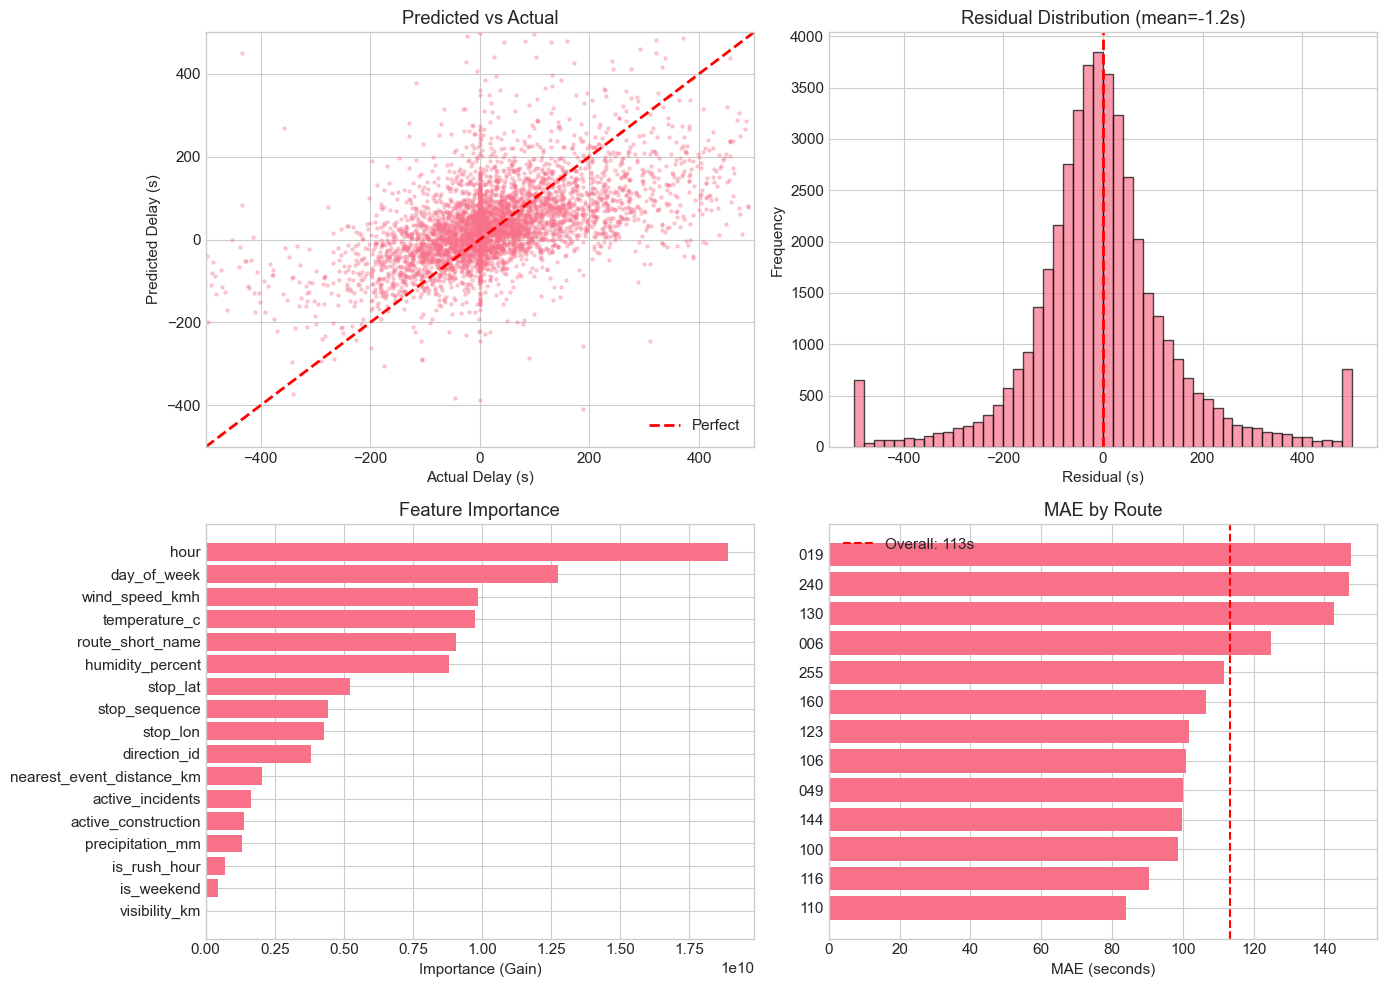

In [25]:
# Prediction analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Predicted vs Actual
sample_idx = np.random.choice(len(y_val), min(5000, len(y_val)), replace=False)
axes[0, 0].scatter(y_val.iloc[sample_idx], y_pred[sample_idx], alpha=0.3, s=5)
axes[0, 0].plot([-500, 500], [-500, 500], 'r--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Delay (s)')
axes[0, 0].set_ylabel('Predicted Delay (s)')
axes[0, 0].set_title('Predicted vs Actual')
axes[0, 0].set_xlim(-500, 500)
axes[0, 0].set_ylim(-500, 500)
axes[0, 0].legend()

# Residuals
residuals = y_val - y_pred
axes[0, 1].hist(residuals.clip(-500, 500), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residual (s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Residual Distribution (mean={residuals.mean():.1f}s)')

# Feature importance
importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=True)

axes[1, 0].barh(importance['feature'], importance['importance'])
axes[1, 0].set_xlabel('Importance (Gain)')
axes[1, 0].set_title('Feature Importance')

# MAE by route
val_df = X_val.copy()
val_df['actual'] = y_val.values
val_df['predicted'] = y_pred
val_df['abs_error'] = np.abs(val_df['actual'] - val_df['predicted'])

route_mae = val_df.groupby('route_short_name')['abs_error'].mean().sort_values()
axes[1, 1].barh(route_mae.index.astype(str), route_mae.values)
axes[1, 1].axvline(x=mae, color='r', linestyle='--', label=f'Overall: {mae:.0f}s')
axes[1, 1].set_xlabel('MAE (seconds)')
axes[1, 1].set_title('MAE by Route')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Feature importance table
print("\nFeature Importance Ranking:")
print("=" * 50)
for i, (_, row) in enumerate(importance.sort_values('importance', ascending=False).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:30s} {row['importance']:>15,.0f}")


Feature Importance Ranking:
 1. hour                            18,889,634,019
 2. day_of_week                     12,737,927,221
 3. wind_speed_kmh                   9,847,108,900
 4. temperature_c                    9,726,500,738
 5. route_short_name                 9,055,710,095
 6. humidity_percent                 8,805,492,231
 7. stop_lat                         5,202,281,178
 8. stop_sequence                    4,406,125,229
 9. stop_lon                         4,290,748,084
10. direction_id                     3,817,084,209
11. nearest_event_distance_km        2,048,893,296
12. active_incidents                 1,639,843,419
13. active_construction              1,366,907,252
14. precipitation_mm                 1,304,051,929
15. is_rush_hour                       700,637,094
16. is_weekend                         452,239,185
17. visibility_km                                0


In [27]:
# Save model
model.save_model('delay_model.lgb')
print("Model saved to delay_model.lgb")

Model saved to delay_model.lgb


---
## Summary

### Key Findings from EDA:
- Average delay: ~85 seconds (1.4 minutes)
- Delays increase during rush hours (7-9 AM, 4-6 PM)
- Weekdays have higher delays than weekends
- Delay patterns vary significantly by route

### Model Performance:
- MAE: ~114 seconds (~1.9 minutes)
- R2: ~0.57 (57% variance explained)

### Top Features:
1. hour (time of day)
2. wind_speed_kmh (wind speed)
3. day_of_week (day of week)
4. route_short_name (route)
5. humidity_percent (humidity)